# Experiments vs simulations: Quads design (3dp pla + blue shims) for energy focusing


## Imports


In [28]:
import matplotlib
import matplotlib.pyplot as plt
from typing import Literal, Union, List
from difflexmm.plotting import generate_animation
from difflexmm.geometry import compute_inertia
from difflexmm.energy import compute_ligament_strains, compute_ligament_strains_history
from difflexmm.utils import save_data, load_data, SolutionData
from scripts.tracking.utils import smooth_fields_SG
from problems.quads_focusing import OptimizationProblem
import cv2

from pathlib import Path
import pandas as pd
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type

plt.style.use(["science", "grid"])
%matplotlib widget

## Paths

In [29]:
# Where to load/save data
data_folder = Path("../../data/quads_focusing_3dp_pla_shims")
# Where to save plots and animations
out_folder = Path("../../out/quads_focusing_3dp_pla_shims")

## Problem info


NOTE: Either define the problem info here or load it from an optimization file.


In [30]:
# NOTE: Units are mm, N, s

# Retrieve design info from optimization data
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_2x2_target_shift_4x5"
optimization = OptimizationProblem.from_dict(
    load_data(
        f"{data_folder}/{optimization_filename}.pkl",
    )
)
problem = optimization.forward_problem
# Set up the forward problem
problem.setup()
geometry = problem.geometry

# Select the best design
design_values = optimization.design_values[-1]

# Subfolder for videos and tracking data
design_name = optimization_filename


## Load tracking data


In [31]:
# Find all data files in the dynamic-data folder
simulation_data_paths = sorted(list(Path(
    f"{data_folder}/{design_name}/dynamic-data/tracking_exp/").glob("*.pkl")), key=lambda p: p.stem[-2:])

# Load the tracked data as a dataframe
# NOTE: Make sure the filenames are consistent as voltages and frequencies are extracted from the filenames.
tracked_data = pd.DataFrame({
    "label": [p.stem for p in simulation_data_paths],
    "shaker_mode": [p.stem.split("_")[-4] for p in simulation_data_paths],
    "voltage": [float(p.stem.split("_")[-3][:-2]) for p in simulation_data_paths],
    "frequency": [float(p.stem.split("_")[-2][:-2]) for p in simulation_data_paths],
    "data": [SolutionData(**load_data(p)) for p in simulation_data_paths],
})

excited_blocks_ids = problem.driven_blocks_ids
tracked_data


,label,shaker_mode,voltage,frequency,data
0,exp_shaker_burst_50mV_30Hz_F01,burst,50.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
1,exp_shaker_burst_75mV_30Hz_F02,burst,75.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
2,exp_shaker_burst_100mV_30Hz_F03,burst,100.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
3,exp_shaker_burst_125mV_30Hz_F04,burst,125.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
4,exp_shaker_burst_150mV_30Hz_F05,burst,150.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
5,exp_shaker_burst_175mV_30Hz_F06,burst,175.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
6,exp_shaker_burst_200mV_30Hz_F07,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
7,exp_shaker_burst_225mV_30Hz_F08,burst,225.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
8,exp_shaker_burst_200mV_30Hz_F12,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
9,exp_shaker_burst_200mV_30Hz_F13,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."


## Solve forward simulation with experimental input


In [ ]:
# NOTE: Filter experiments that we want to simulate
tracked_data_to_simulate = tracked_data  # [(tracked_data["voltage"] <= 100.)]

for row in tracked_data_to_simulate.itertuples():
    # Interpolate the shaker input to the simulation timepoints
    def excited_blocks_fn(t):
        return jnp.interp(t, row.data.timepoints - row.data.timepoints[0], row.data.fields[:, 0, excited_blocks_ids[0], 0])
    # Setup the problem
    problem.simulation_time = row.data.timepoints[-1] - row.data.timepoints[0]
    problem.n_timepoints = len(row.data.timepoints)
    problem.setup(excited_blocks_fn=excited_blocks_fn)
    # Solve the problem
    solution_data = problem.solve(design_values)
    # Save the solution
    save_data(
        f"{data_folder}/{design_name}/dynamic-data/simulation_exp/{row.label}.pkl",
        solution_data._asdict()
    )


## Load simulation data


In [32]:
# Find all data files in the dynamic-data folder
simulation_data_paths = sorted(list(Path(
    f"{data_folder}/{design_name}/dynamic-data/simulation_exp/").glob("*.pkl")), key=lambda p: p.stem[-2:])

# Load the simulation data as a dataframe
# NOTE: Make sure the filenames are consistent as voltages and frequencies are extracted from the filenames.
simulation_data = pd.DataFrame({
    "label": [p.stem for p in simulation_data_paths],
    "shaker_mode": [p.stem.split("_")[-4] for p in simulation_data_paths],
    "voltage": [float(p.stem.split("_")[-3][:-2]) for p in simulation_data_paths],
    "frequency": [float(p.stem.split("_")[-2][:-2]) for p in simulation_data_paths],
    "data": [SolutionData(**load_data(p)) for p in simulation_data_paths],
})
simulation_data


,label,shaker_mode,voltage,frequency,data
0,exp_shaker_burst_50mV_30Hz_F01,burst,50.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
1,exp_shaker_burst_75mV_30Hz_F02,burst,75.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
2,exp_shaker_burst_100mV_30Hz_F03,burst,100.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
3,exp_shaker_burst_125mV_30Hz_F04,burst,125.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
4,exp_shaker_burst_150mV_30Hz_F05,burst,150.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
5,exp_shaker_burst_175mV_30Hz_F06,burst,175.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
6,exp_shaker_burst_200mV_30Hz_F07,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
7,exp_shaker_burst_225mV_30Hz_F08,burst,225.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
8,exp_shaker_burst_200mV_30Hz_F12,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."
9,exp_shaker_burst_200mV_30Hz_F13,burst,200.0,30.0,"([[-1.4360886458555562e-16, 1.4360886458555562..."


## Compare experiments and simulations


### Plotting functions


In [6]:
def exp_vs_sim_error(simulation_data, tracked_data):
    return jnp.linalg.norm(
        simulation_data.fields[:, 0, :, :2] - tracked_data.fields[:, 0, :, :2],
        axis=-1
    )


def exp_vs_sim_error_min_max(simulation_data, tracked_data):
    error_min = jnp.abs(simulation_data.fields[:, 0, :, :].min(axis=0) - tracked_data.fields[:, 0, :, :].min(axis=0))
    error_max = jnp.abs(simulation_data.fields[:, 0, :, :].max(axis=0) - tracked_data.fields[:, 0, :, :].max(axis=0))
    return error_min, error_max


In [7]:
from matplotlib.colors import LinearSegmentedColormap


def plot_exp_vs_sim_error_evolution(simulation_data, tracked_data):
    fig, axes = plt.subplots(figsize=(7, 3), constrained_layout=True)
    axes.plot(
        tracked_data.timepoints,
        exp_vs_sim_error(simulation_data, tracked_data),
        lw=1,
        color="gray",
        alpha=0.2
    )

    axes.set(xlabel="Time [s]", ylabel="Displacement error [mm]")
    axes.set(title="Experiment vs simulation - Error evolution")
    return fig, axes


def plot_exp_vs_sim_error_contour(simulation_data, tracked_data):
    fig, axes = plt.subplots(figsize=(7, 7*(geometry.n2_blocks)/geometry.n1_blocks), constrained_layout=True)
    plot = axes.tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        exp_vs_sim_error(simulation_data, tracked_data).max(axis=0),
        levels=50
    )

    axes.set(xlabel="x [mm]", ylabel="y [mm]")
    axes.set(title="Experiment vs simulation - Max instantaneous error")
    axes.axis("equal")
    fig.colorbar(plot, label="Max instantaneous error [mm]", pad=0.02)
    return fig, axes


def plot_exp_vs_sim_min_max_error_contour(simulation_data, tracked_data):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4.5), sharex=True, sharey=True, constrained_layout=True)

    error_min, error_max = exp_vs_sim_error_min_max(simulation_data, tracked_data)

    plot = axes[0][0].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_max[:, :2].max(axis=-1),
        levels=50
    )

    axes[0][0].set(ylabel="y [mm]", aspect="equal")
    fig.colorbar(plot, ax=axes[0][0], label="Peak displacement error [mm]", pad=0.02)

    plot = axes[0][1].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_min[:, :2].max(axis=-1),
        levels=50
    )

    axes[0][1].set(aspect="equal")
    fig.colorbar(plot, ax=axes[0][1], label="Trough displacement error [mm]", pad=0.02)

    plot = axes[1][0].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_max[:, 2],
        levels=50
    )

    axes[1][0].set(xlabel="x [mm]", ylabel="y [mm]", aspect="equal")
    fig.colorbar(plot, ax=axes[1][0], label="Peak rotation error [rad]", pad=0.02)

    plot = axes[1][1].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_min[:, 2],
        levels=50
    )

    axes[1][1].set(xlabel="x [mm]", aspect="equal")
    fig.colorbar(plot, ax=axes[1][1], label="Trough rotation error [rad]", pad=0.02)
    return fig, axes


def plot_error(simulation_data, tracked_data):
    plot_exp_vs_sim_error_evolution(simulation_data, tracked_data)
    plot_exp_vs_sim_error_contour(simulation_data, tracked_data)
    plot_exp_vs_sim_min_max_error_contour(simulation_data, tracked_data)


def block_ids_row(row_id):
    return jnp.arange(geometry.n1_blocks) + row_id * geometry.n1_blocks


def block_ids_column(column_id):
    return jnp.arange(geometry.n2_blocks) * geometry.n1_blocks + column_id


def plot_field_history_along_section(simulation_data, tracked_data, field_id, block_ids):
    fig, axes = plt.subplots(figsize=(7, 3), constrained_layout=True)
    axes.plot(
        tracked_data.timepoints,
        tracked_data.fields[:, field_id[0], block_ids, field_id[1]],
        lw=1,
        color="#2c3e50",
        label="Experiment",
    )
    axes.plot(
        simulation_data.timepoints,
        simulation_data.fields[:, field_id[0], block_ids, field_id[1]],
        lw=1,
        color="#2980b9",
        label="Simulation",
    )
    axes.set(xlabel="Time [s]", ylabel="DOF")
    dof_label = ["x", "y", "theta"][field_id[1]]
    axes.set(title=f"Experiment vs simulation - DOF: {'Displacement' if field_id[0]==0 else 'Velocity'}-{dof_label}")
    axes.legend(["Experiment", "Simulation"])
    return fig, axes


def energy_profile(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def plot_max_field_profile_x_section(comparison_data, row_id, field: Literal["u", "v", "k"], target_response=None, synthetic_responses=None, figsize=(10, 4), fontsize=14, grid=True):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    # Colors based on amplitude
    colors = [
        plt.get_cmap("Blues")((lambda x: 0.3 + (x-comparison_data.amplitude.min())*(1-0.3)/(comparison_data.amplitude.max()-comparison_data.amplitude.min()))(row.amplitude)) for row in comparison_data.itertuples()
    ]

    simulation_data_list = comparison_data.simulation_data.values
    tracked_data_list = comparison_data.tracked_data.values
    # labels = [
    #     f"{row.label.split('_')[-1]}: {row.voltage:.0f}mV, {row.frequency:.0f}Hz" for row in comparison_data.itertuples()
    # ]
    labels = [
        f"{row.amplitude:.0f}mm, {row.frequency:.0f}Hz" for row in comparison_data.itertuples()
    ]
    if field == "u":
        def field_values_fn(data): return jnp.linalg.norm(
            data.fields[:, 0, block_ids_row(row_id), :2], axis=-1).max(axis=0)
        ylabel = "Peak displacement [mm]"
    elif field == "v":
        def field_values_fn(data): return jnp.linalg.norm(
            data.fields[:, 1, block_ids_row(row_id), :2], axis=-1).max(axis=0)*1e-3
        ylabel = "Peak velocity [m/s]"
    elif field == "k":
        def field_values_fn(data):
            blocks_inertia = compute_inertia(vertices=data.centroid_node_vectors, density=problem.density)
            return energy_profile(
                data.fields[:, 1, block_ids_row(row_id), :],
                blocks_inertia[block_ids_row(row_id)]
            ).max(axis=0)
        ylabel = "Peak kinetic energy [mJ]"
    else:
        raise ValueError(f"Unknown field: {field}")

    for simulation_data, tracked_data, color, label in zip(simulation_data_list, tracked_data_list, colors, labels):
        axes.plot(
            jnp.arange(geometry.n1_blocks),
            field_values_fn(tracked_data),
            lw=3,
            ls="--",
            color=color,
            label=f"Experiment: {label}",
        )
        axes.plot(
            jnp.arange(geometry.n1_blocks),
            field_values_fn(simulation_data),
            lw=3,
            ls="-",
            color=color,
            label=f"Simulation: {label}",
        )

    if target_response is not None:
        axes.plot(
            jnp.arange(geometry.n1_blocks),
            field_values_fn(target_response),
            lw=2,
            ls="-",
            color="firebrick",
            label=f"Target response",
        )

    if synthetic_responses is not None:
        cmap = plt.get_cmap("Oranges")
        colors = [cmap(i) for i in jnp.linspace(0.4, 1, len(synthetic_responses))]
        for synthetic_response, color in zip(synthetic_responses, colors):
            axes.plot(
                jnp.arange(geometry.n1_blocks),
                field_values_fn(synthetic_response),
                lw=2,
                ls="-",
                color=color,
                label=f"Synthetic response",
            )

    axes.axvspan(
        (geometry.n1_blocks - optimization.target_size[0]-1)/2 + optimization.target_shift[0],
        (geometry.n1_blocks + optimization.target_size[0]-1)/2 + optimization.target_shift[0],
        color="#27ae60", alpha=0.3, label="Focusing region"
    )
    axes.axhline(y=0, color="black")
    axes.set_xlabel(r"$x$-direction [\# units]", fontsize=fontsize)
    axes.set_ylabel(ylabel, fontsize=fontsize)
    axes.tick_params(labelsize=fontsize)

    axes.legend(loc="upper left", framealpha=0.8, fontsize=fontsize)

    if not grid:
        axes.grid(False)

    return fig, axes


def plot_shaker_input_paper(comparison_data, target_response=None, figsize=(7, 3), fontsize=14, xlim=None, ylim=None, legend=True, synthetic_inputs=[], lw=2, colors=None):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    # Colors based on amplitude
    colors = [
        plt.get_cmap("Blues")((lambda x: 0.3 + (x-comparison_data.amplitude.min())*(1-0.3)/(comparison_data.amplitude.max()-comparison_data.amplitude.min()))(row.amplitude)) for row in comparison_data.itertuples()
    ] if colors is None else colors

    for row, color in zip(comparison_data.itertuples(), colors):
        axes.plot(
            row.tracked_data.timepoints*1e3,
            row.tracked_data.fields[:, 0, excited_blocks_ids[0], 0],
            label=f"{row.label.split('_')[-1]}: {row.voltage:.0f}mV, {row.frequency:.0f}Hz",
            lw=lw,
            color=color,
        )

    if len(synthetic_inputs) > 0:
        # Use an orange to white colormap for synthetic inputs
        cmap = plt.get_cmap("Oranges")
        colors = [cmap(i) for i in jnp.linspace(0.4, 1, len(synthetic_inputs))]
        for (amp, freq), color in zip(synthetic_inputs, colors):
            timepoints = comparison_data.iloc[0].tracked_data.timepoints
            delay = timepoints[jnp.where(comparison_data.iloc[0].tracked_data.fields[:,
                                         0, excited_blocks_ids[0], 0] > 1e-2)[0][0]]
            axes.plot(
                timepoints*1e3,
                (lambda t: jnp.where((t > 0.) & (t < freq**-1), amp *
                                     (1-jnp.cos(2*jnp.pi*freq*t))/2, 0.))(timepoints-delay),
                lw=lw,
                ls="-",
                color=color,
                label=f"Synthetic input",
            )
    if target_response is not None:
        timepoints = comparison_data.iloc[0].tracked_data.timepoints
        delay = timepoints[jnp.where(comparison_data.iloc[0].tracked_data.fields[:,
                                     0, excited_blocks_ids[0], 0] > 1e-2)[0][0]]
        axes.plot(
            timepoints*1e3,
            (lambda t: jnp.where((t > 0.) & (t < problem.loading_rate**-1), problem.amplitude *
             (1-jnp.cos(2*jnp.pi*problem.loading_rate*t))/2, 0.))(timepoints-delay),
            lw=lw,
            ls="-",
            color="firebrick",
            label=f"Ideal input",
        )

    axes.axhline(0, color="black", ls="-", lw=1, zorder=0)
    axes.set_xlabel("Time [ms]", fontsize=fontsize)
    axes.set_ylabel("Displacement [mm]", fontsize=fontsize)
    axes.tick_params(labelsize=fontsize)
    # axes.set_title("Experimental input", fontsize=fontsize)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(loc='upper right')
    axes.grid(False)

    return fig, axes


def plot_energy_evolution_list(comparison_data, block_ids=None, figsize=(10, 7), fontsize=None, grid=True, energy_ratio=False):

    fig, axes = plt.subplots(figsize=figsize, sharex=True, constrained_layout=True)
    # Colors based on amplitude
    colors = [
        plt.get_cmap("Blues")((lambda x: 0.3 + (x-comparison_data.amplitude.min())*(1-0.3)/(comparison_data.amplitude.max()-comparison_data.amplitude.min()))(row.amplitude)) for row in comparison_data.itertuples()
    ]

    simulation_data_list = comparison_data.simulation_data.values
    tracked_data_list = comparison_data.tracked_data.values
    # labels = [
    #     f"{row.label.split('_')[-1]}: {row.voltage:.0f}mV, {row.frequency:.0f}Hz" for row in comparison_data.itertuples()
    # ]
    labels = [
        f"{row.amplitude:.0f}mm, {row.frequency:.0f}Hz" for row in comparison_data.itertuples()
    ]

    _block_ids = block_ids if block_ids is not None else jnp.arange(simulation_data_list[0].block_centroids.shape[0])
    if block_ids == "target":
        target_size = optimization.target_size
        target_shift = optimization.target_shift
        _block_ids = jnp.array([
            j * problem.n1_blocks + i
            for i in range((problem.n1_blocks-target_size[0])//2 + target_shift[0], (problem.n1_blocks+target_size[0])//2 + target_shift[0])
            for j in range((problem.n2_blocks-target_size[1])//2 + target_shift[1], (problem.n2_blocks+target_size[1])//2 + target_shift[1])
        ])

    if energy_ratio:
        def field_values_fn(data):
            return jnp.sum(
                energy_profile(
                    data.fields[:, 1, _block_ids, :],
                    compute_inertia(vertices=data.centroid_node_vectors,
                                    density=problem.density)[_block_ids]
                ),
                axis=-1
            )/jnp.sum(
                energy_profile(
                    data.fields[:, 1, jnp.setdiff1d(jnp.arange(data.block_centroids.shape[0]), _block_ids), :],
                    compute_inertia(vertices=data.centroid_node_vectors,
                                    density=problem.density)[jnp.setdiff1d(jnp.arange(data.block_centroids.shape[0]), _block_ids)]
                ),
                axis=-1
            )
    else:
        def field_values_fn(data):
            return jnp.sum(
                energy_profile(
                    data.fields[:, 1, _block_ids, :],
                    compute_inertia(vertices=data.centroid_node_vectors,
                                    density=problem.density)[_block_ids]
                ),
                axis=-1
            )

    for simulation_data, tracked_data, color, label in zip(simulation_data_list, tracked_data_list, colors, labels):
        axes.plot(
            tracked_data.timepoints*1e3,
            field_values_fn(tracked_data),
            lw=3,
            ls="--",
            color=color,
            label=f"Experiment: {label}",
        )
        axes.plot(
            simulation_data.timepoints*1e3,
            field_values_fn(simulation_data),
            lw=3,
            ls="-",
            color=color,
            label=f"Simulation: {label}",
        )

    axes.set_xlabel(r"Time [ms]", fontsize=fontsize)
    if block_ids == "target":
        axes.set_ylabel("Target kinetic energy [mJ]" if not energy_ratio else "Kinetic energy ratio", fontsize=fontsize)
    else:
        axes.set_ylabel("Kinetic energy [mJ]", fontsize=fontsize)
    axes.axhline(y=0, color="black")
    axes.legend(loc="upper right", framealpha=0.8, fontsize=0.8*fontsize, fancybox=True)
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    return fig, axes

In [8]:
from matplotlib import cm, colors
from difflexmm.geometry import compute_xy_limits


def plot_strain_field(solution_data: SolutionData, timepoint: Union[int, Literal["peak", "mean"]] = "peak", ax=None, xlim=None, ylim=None, figsize=(4.5, 9), fontsize=14, grid=True, cmap="inferno"):
    titles = ["Axial strain", "Shear strain", "Bending strain"]
    if ax is None:
        _, axes = plt.subplots(nrows=3, figsize=figsize,
                               sharex=True, constrained_layout=True)
    fig = axes[0].get_figure()
    for ax, title in zip(axes, titles):
        ax.tick_params(labelsize=fontsize)
    axes[-1].set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    fig.supylabel(r"$y$ [mm]", fontsize=fontsize)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    if type(timepoint) is int:
        displacement = solution_data.fields[timepoint, 0]
        # Compute strain field
        strain_fields = compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        strain_fields = [jnp.abs(field) for field in strain_fields]
    elif timepoint == "peak":
        # Compute strain field history and select peak of absolute value
        strain_fields = compute_ligament_strains_history(
            solution_data.fields[:, 0], solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        strain_fields = [jnp.abs(field).max(axis=0) for field in strain_fields]
    elif timepoint == "mean":
        # Compute strain field history and select peak of absolute value
        strain_fields = compute_ligament_strains_history(
            solution_data.fields[:, 0], solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        strain_fields = [jnp.abs(field).mean(axis=0)
                         for field in strain_fields]

    # Strain values limits
    strain_min, strain_max = (
        jnp.array(strain_fields).min(), jnp.array(strain_fields).max())

    for ax, values in zip(axes, strain_fields):
        ax.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], values,
            cmap=cmap, vmin=strain_min, vmax=strain_max, shading='gouraud',
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes:
        # ax.set(xlim=xlim, ylim=ylim)
        ax.axis("equal")
        # Remove padding
        # ax.margins(0)

    cb = fig.colorbar(axes[0].collections[0], ax=axes[-1],
                      pad=0.02, orientation="horizontal", location="bottom")
    cb.ax.tick_params(labelsize=fontsize)
    cb.set_label(r"Strain [-]", fontsize=fontsize)

    if not grid:
        for ax in axes:
            ax.grid(False)

    return fig, axes


def plot_strain_field_evolution(solution_data: SolutionData, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap="inferno"):
    strain_labels = ["Axial strain", "Shear strain", "Bending strain"]
    time_labels = [
        f"$t$ = {solution_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=3, ncols=len(timepoints), figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[:, 0], strain_labels):
        ax.tick_params(labelleft=False, left=False)
        ax.set_ylabel(label, fontsize=fontsize)
    for ax in axes[:, -1]:
        ax.yaxis.set_label_position("right")
        # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize, labelleft=False, labelright=True)
    for ax in axes[-1]:
        # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
    for ax, label in zip(axes[0], time_labels):
        ax.set_title(label, fontsize=fontsize)
    # Add supxlabel at the bottom
    fig.supxlabel(r"$x$ [mm]", fontsize=fontsize)
    # Add supylabel on the right
    fig.supylabel(r"$y$ [mm]", fontsize=fontsize, rotation=90, x=0.915)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    # Compute strain field
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        for displacement in displacements]
    strain_fields = jnp.abs(jnp.array(strain_fields))

    # Strain values limits
    strain_min, strain_max = (strain_fields.min(), strain_fields.max())

    for i, ax_col in enumerate(axes.T):
        for ax, values in zip(ax_col, strain_fields[i]):
            ax.tripcolor(
                bond_midpoints[:, 0], bond_midpoints[:, 1], values,
                cmap=cmap, vmin=strain_min, vmax=strain_max, shading='gouraud',
            )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    cb = fig.colorbar(axes[0][0].collections[0], ax=axes[:, -1], pad=0.15,
                      aspect=30, orientation="vertical", location="right")
    cb.ax.tick_params(labelsize=fontsize)
    cb.set_label(r"Strain [-]", fontsize=fontsize)

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_strain_field_evolution_no_axial(solution_data: SolutionData, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap="inferno"):
    strain_labels = ["Shear strain", "Bending strain"]
    time_labels = [
        f"$t$ = {solution_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=2, ncols=len(timepoints), figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[:, 0], strain_labels):
        ax.tick_params(labelleft=False, left=False)
        ax.set_ylabel(label, fontsize=fontsize)
    for ax in axes[:, -1]:
        ax.yaxis.set_label_position("right")
        # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize, labelleft=False, labelright=True)
    for ax in axes[-1]:
        # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
    for ax, label in zip(axes[0], time_labels):
        ax.set_title(label, fontsize=fontsize)
    # Add supxlabel at the bottom
    fig.supxlabel(r"$x$ [mm]", fontsize=fontsize)
    # Add supylabel on the right
    fig.supylabel(r"$y$ [mm]", fontsize=fontsize, rotation=90, x=0.915)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    # Compute strain field
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)[1:]
        for displacement in displacements]
    strain_fields = jnp.abs(jnp.array(strain_fields))

    # Strain values limits
    strain_min, strain_max = (strain_fields.min(), strain_fields.max())

    for i, ax_col in enumerate(axes.T):
        for ax, values in zip(ax_col, strain_fields[i]):
            ax.tripcolor(
                bond_midpoints[:, 0], bond_midpoints[:, 1], values,
                cmap=cmap, vmin=strain_min, vmax=strain_max, shading='gouraud',
            )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    cb = fig.colorbar(axes[0][0].collections[0], ax=axes[:, -1], pad=0.15,
                      aspect=30, orientation="vertical", location="right")
    cb.ax.tick_params(labelsize=fontsize)
    cb.set_label(r"Strain [-]", fontsize=fontsize)

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_strain_field_evolution_no_axial_T(solution_data: SolutionData, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap="inferno"):
    strain_labels = ["Shear strain", "Bending strain"]
    time_labels = [
        f"$t$ = {solution_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=len(timepoints), ncols=2, figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[0], strain_labels):
        ax.set_title(label, fontsize=fontsize)
    for ax in axes[-1]:
        # ax.yaxis.set_label_position("right")
        # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
    for ax, label in zip(axes[:, -1], time_labels):
        # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(label, fontsize=fontsize, labelpad=6)
    for ax in axes[:, 0]:
        ax.tick_params(labelsize=fontsize)
    # Add supxlabel at the bottom
    fig.supxlabel(r"$x$ [mm]", fontsize=fontsize, x=0.55,
                  y=0.105, ha="center", va="center")
    # Add supylabel on the right
    fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                  y=0.55, ha="left", va="center")

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    # Compute strain field
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)[1:]
        for displacement in displacements]
    strain_fields = jnp.abs(jnp.array(strain_fields))

    # Strain values limits
    strain_min, strain_max = (strain_fields.min(), strain_fields.max())

    for i, ax_row in enumerate(axes):
        for ax, values in zip(ax_row, strain_fields[i]):
            ax.tripcolor(
                bond_midpoints[:, 0], bond_midpoints[:, 1], values,
                cmap=cmap, vmin=strain_min, vmax=strain_max, shading='gouraud',
            )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    cb = fig.colorbar(axes[0][0].collections[0], ax=axes[-1], pad=0.2,
                      aspect=25, orientation="horizontal", location="bottom")
    cb.ax.tick_params(labelsize=fontsize)
    cb.set_label(r"Strain [-]", fontsize=fontsize)

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_strain_and_kinetic_energy_evolution(solution_data: SolutionData, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap="inferno"):
    column_labels = ["Strain energy", "Kinetic energy"]
    time_labels = [
        f"$t$ = {solution_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=len(timepoints), ncols=2, figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[0], column_labels):
        ax.set_title(label, fontsize=fontsize)
    for ax in axes[-1]:
        # ax.yaxis.set_label_position("right")
        # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
    for ax, label in zip(axes[:, -1], time_labels):
        # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(label, fontsize=fontsize, labelpad=6)
    for ax in axes[:, 0]:
        ax.tick_params(labelsize=fontsize)
    # Add supxlabel at the bottom
    fig.supxlabel(r"$x$ [mm]", fontsize=fontsize, x=0.55,
                  y=0.105, ha="center", va="center")
    # Add supylabel on the right
    fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                  y=0.55, ha="left", va="center")

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    velocities = [solution_data.fields[timepoint, 1]
                  for timepoint in timepoints]
    # Compute strain energy
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        for displacement in displacements]
    strain_fields = jnp.array(strain_fields)
    strain_energies = jnp.array([
        problem.k_stretch*strain_fields_i[0]**2/2 + problem.k_shear *
        strain_fields_i[1]**2/2 + problem.k_rot*strain_fields_i[2]**2/2
        for strain_fields_i in strain_fields
    ])**0.5
    # Strain energy values limits
    strain_energy_min, strain_energy_max = jnp.min(
        strain_energies), jnp.max(strain_energies)

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        energy_profile(
            velocity,
            compute_inertia(
                vertices=solution_data.centroid_node_vectors, density=problem.density),
        ) for velocity in velocities
    ])**0.5
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    energy_min, energy_max = min(strain_energy_min, kinetic_energy_min), max(
        strain_energy_max, kinetic_energy_max)

    # Plot strain energies in the left column
    for ax, strain_energy in zip(axes[:, 0], strain_energies):
        ax.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], strain_energy,
            cmap=cmap, vmin=energy_min, vmax=energy_max, shading='gouraud',
        )
    # Plot kinetic energies in the right column
    for ax, kinetic_energy in zip(axes[:, 1], kinetic_energies):
        ax.tripcolor(
            solution_data.block_centroids[:,
                                          0], solution_data.block_centroids[:, 1], kinetic_energy,
            cmap=cmap, vmin=energy_min, vmax=energy_max, shading='gouraud',
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    cb = fig.colorbar(axes[0][0].collections[0], ax=axes[-1], pad=0.2,
                      aspect=25, orientation="horizontal", location="bottom")
    cb.ax.tick_params(labelsize=fontsize)
    cb.set_label(r"Strain and kinetic energy [mJ]", fontsize=fontsize)

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_strains_and_kinetic_energy_evolution(solution_data: SolutionData, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap_strains="inferno", cmap_kinetic="inferno", show_ticks=True, time_label_pos="right"):
    column_labels = ["Shear", "Bending", "Kinetic"]
    time_labels = [
        f"$t$ = {solution_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=len(timepoints), ncols=3, figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[0], column_labels):
        ax.set_title(label, fontsize=fontsize)
    # Remove all ticks
    if not show_ticks:
        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        # Add supxlabel at the bottom
        fig.supxlabel(r"$x$ [mm]", fontsize=fontsize,
                      x=0.55, y=0.1, ha="center", va="center")
        # Add supylabel on the right
        fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                      y=0.55, ha="left", va="center")
        for ax in axes[-1]:
            # ax.yaxis.set_label_position("right")
            # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, 0]:
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, -1]:
            # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)

    # Add time labels on the right
    if time_label_pos == "right":
        for ax, label in zip(axes[:, -1], time_labels):
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(label, fontsize=0.8*fontsize, labelpad=4)
    elif time_label_pos == "left":
        for ax, label in zip(axes[:, 0], time_labels):
            ax.set_ylabel(label, fontsize=0.8*fontsize, labelpad=4)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    velocities = [solution_data.fields[timepoint, 1]
                  for timepoint in timepoints]
    # Compute strain energy
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        for displacement in displacements]
    strain_fields = jnp.array(strain_fields)
    strain_energies = jnp.array([
        [problem.k_shear * (strain_fields_i[1]*problem.bond_length)
         ** 2/2, problem.k_rot*strain_fields_i[2]**2/2]
        for strain_fields_i in strain_fields
    ])
    # Strain energy values limits
    strain_energy_min, strain_energy_max = jnp.min(
        strain_energies), jnp.max(strain_energies)

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        energy_profile(
            velocity,
            compute_inertia(
                vertices=solution_data.centroid_node_vectors, density=problem.density),
        ) for velocity in velocities
    ])
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    # energy_min, energy_max = min(strain_energy_min, kinetic_energy_min), max(strain_energy_max, kinetic_energy_max)

    # Plot strain energies in the first two
    for (ax0, ax1), (shear_energy, bending_energy) in zip(axes[:, :2], strain_energies):
        ax0.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], shear_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
        ax1.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], bending_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
    # Plot kinetic energies in the right column
    for ax, kinetic_energy in zip(axes[:, -1], kinetic_energies):
        ax.tripcolor(
            solution_data.block_centroids[:,
                                          0], solution_data.block_centroids[:, 1], kinetic_energy,
            cmap=cmap_kinetic, shading='gouraud',
            norm=colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min,
                                  vmax=kinetic_energy_max,),  # gamma=1./2. for sqrt
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    # Remove all ticks and axes labels
    # for ax in axes.flatten():
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])

    strain_mappable = cm.ScalarMappable(norm=colors.PowerNorm(gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
                                        cmap=cmap_strains)
    kinetic_mappable = cm.ScalarMappable(norm=colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min, vmax=kinetic_energy_max,),
                                         cmap=cmap_kinetic)
    cb_strains = fig.colorbar(strain_mappable, ax=axes[-1, :2], pad=0.25 if show_ticks else 0.08, aspect=25,
                              orientation="horizontal", location="bottom")
    cb_strains.ax.tick_params(labelsize=0.8*fontsize)
    cb_strains.set_label(r"Strain energy [mJ]", fontsize=fontsize)
    cb_kinetic = fig.colorbar(kinetic_mappable, ax=axes[-1, -1], pad=0.25 if show_ticks else 0.08, aspect=25*0.47,
                              orientation="horizontal", location="bottom")
    cb_kinetic.ax.tick_params(labelsize=0.8*fontsize)
    cb_kinetic.set_label(r"Kinetic energy [mJ]", fontsize=fontsize)

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes

### Dataframe for comparison


In [33]:
# Create a dataframe to compare the simulation and experimental data
comparison_data = simulation_data.copy()
comparison_data = comparison_data.rename(columns={"data": "simulation_data"})
comparison_data["tracked_data"] = None
# Add the experimental data column
for row in comparison_data.itertuples():
    comparison_data.at[row.Index, "tracked_data"] = tracked_data[tracked_data["label"] == row.label].data.iloc[0]

# Add an amplitude column at position 4 to the comparison dataframe
comparison_data.insert(4, "amplitude", None)
# Add the amplitude values by computing peak displacement of the shaker
for row in comparison_data.itertuples():
    comparison_data.at[row.Index, "amplitude"] = row.tracked_data.fields[:, 0, excited_blocks_ids[0], 0].max()

comparison_data


,label,shaker_mode,voltage,frequency,amplitude,simulation_data,tracked_data
0,exp_shaker_burst_50mV_30Hz_F01,burst,50.0,30.0,1.761853875504497,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
1,exp_shaker_burst_75mV_30Hz_F02,burst,75.0,30.0,2.7734030798333444,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
2,exp_shaker_burst_100mV_30Hz_F03,burst,100.0,30.0,4.096114141898138,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
3,exp_shaker_burst_125mV_30Hz_F04,burst,125.0,30.0,5.229857526689359,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
4,exp_shaker_burst_150mV_30Hz_F05,burst,150.0,30.0,6.138128344995356,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
5,exp_shaker_burst_175mV_30Hz_F06,burst,175.0,30.0,7.166174532842068,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
6,exp_shaker_burst_200mV_30Hz_F07,burst,200.0,30.0,7.912702325962112,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
7,exp_shaker_burst_225mV_30Hz_F08,burst,225.0,30.0,8.716020173747818,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
8,exp_shaker_burst_200mV_30Hz_F12,burst,200.0,30.0,8.01179188006016,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."
9,exp_shaker_burst_200mV_30Hz_F13,burst,200.0,30.0,8.172558362659862,"([[-1.4360886458555562e-16, 1.4360886458555562...","([[-1.4360886458555562e-16, 1.4360886458555562..."


In [ ]:
# # Apply some smoothing to the noisy velocity fields of the tracked data
# from scripts.tracking.utils import smooth_fields_convolution

# for row in comparison_data[comparison_data.voltage <= 200.].itertuples():
#     comparison_data.at[row.Index, "tracked_data"] = comparison_data.at[row.Index, "tracked_data"]._replace(
#         fields=smooth_fields_convolution(
#             comparison_data.at[row.Index, "tracked_data"].fields,
#             kernel_size=[[0, 0, 0], [12, 12, 12]],
#         )
#     )


### Plots


#### Input signals


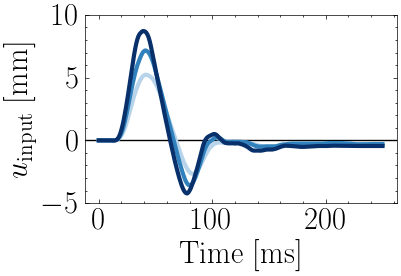

In [ ]:
comparison_data_paper = comparison_data.loc[[3, 5, 7]]
fig, axes = plot_shaker_input_paper(
    comparison_data_paper,
    # target_response=problem.solution_data,
    figsize=(4, 2.75),
    fontsize=22,
    ylim=(-5, 10),
    legend=False,
    # synthetic_inputs=[(7.5, 20), (7.5, 22.5), (7.5, 25), (7.5, 27.5)],
    lw=3,
)
axes.set_ylabel(r"$u_\text{input}$ [mm]", fontsize=22)
# fig.savefig(f"profiles/shaker_inputs.png", bbox_inches="tight", dpi=300)
fig.savefig(
    f"{out_folder}/{optimization_filename}/profiles/shaker_inputs_{comparison_data_paper.voltage.values.tolist()}mV.png", bbox_inches="tight", dpi=300)


#### Field history section


(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Experiment vs simulation - DOF: Displacement-x'}, xlabel='Time [s]', ylabel='DOF'>)

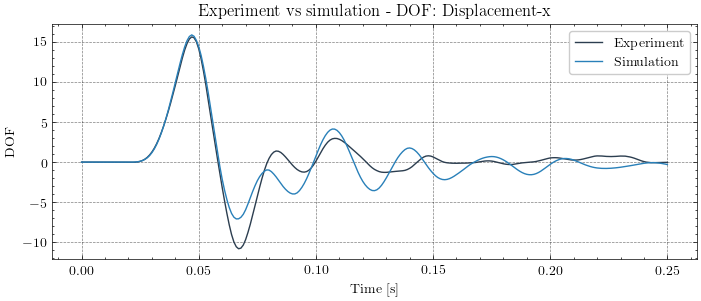

In [ ]:
# One of the target blocks
plot_field_history_along_section(
    comparison_data.loc[7].simulation_data,
    comparison_data.loc[7].tracked_data,
    field_id=(0, 0),
    block_ids=jnp.array([327]),
)


(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Experiment vs simulation - DOF: Displacement-x'}, xlabel='Time [s]', ylabel='DOF'>)

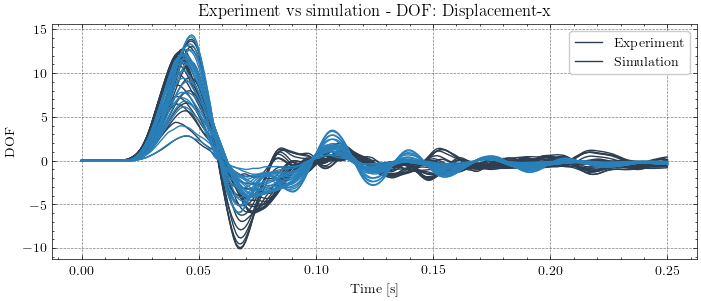

In [ ]:
plot_field_history_along_section(
    comparison_data.loc[7].simulation_data,
    comparison_data.loc[7].tracked_data,
    field_id=(0, 0),
    block_ids=block_ids_row(12),
)


(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Experiment vs simulation - DOF: Velocity-x'}, xlabel='Time [s]', ylabel='DOF'>)

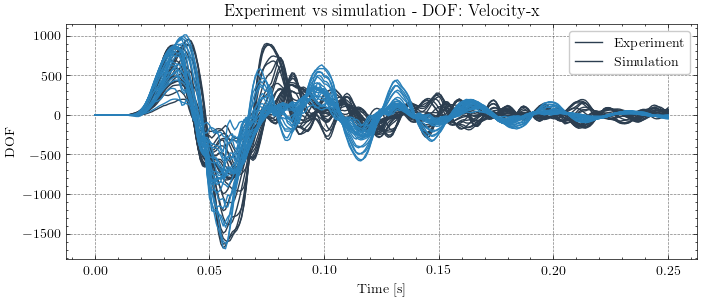

In [ ]:
plot_field_history_along_section(
    comparison_data.loc[7].simulation_data,
    comparison_data.loc[7].tracked_data,
    field_id=(1, 0),
    block_ids=block_ids_row(12),
)


#### Field peak section


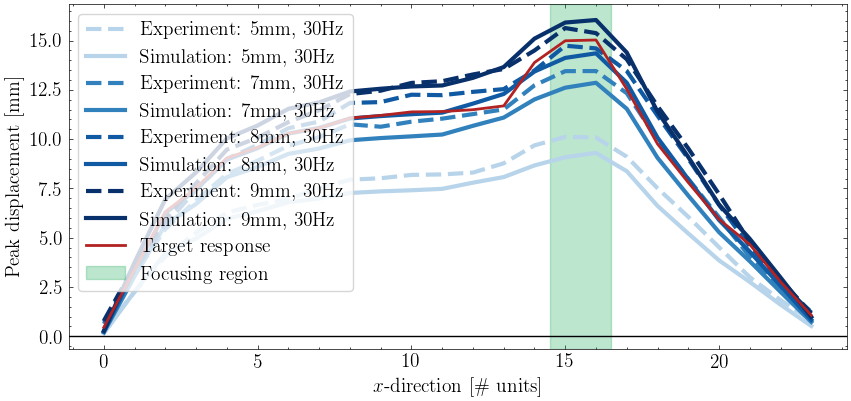

In [ ]:
comparison_data_paper = comparison_data.loc[[3, 5, 6, 7]]
fig, axes = plot_max_field_profile_x_section(
    comparison_data_paper,
    field="u",
    row_id=13,
    target_response=problem.solution_data,
    grid=False,
    figsize=(8.5, 4),
    # fontsize=22,
)
# Remove legend
# axes.legend().remove()
# fig.savefig(
#     f"{out_folder}/{optimization_filename}/profiles/{comparison_data_paper.label.values.tolist()}_displacement_profile_x_section.png", bbox_inches="tight", dpi=300)


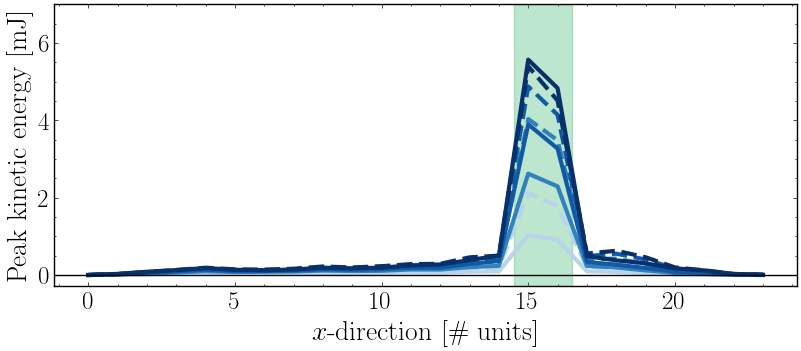

In [23]:
comparison_data_paper = comparison_data.loc[[3, 5, 6, 7]]
fig, axes = plot_max_field_profile_x_section(
    comparison_data_paper,
    field="k",
    row_id=13,
    # target_response=problem.solution_data,
    grid=False,
    figsize=(8, 3.5),
    fontsize=20,
)
# Remove legend
axes.legend().remove()
axes.set_ylim(None, 7)
axes.tick_params(labelsize=18)
# Make spines 1pt thick
for spine in axes.spines.values():
    spine.set_linewidth(1)
out_path = Path(f"{out_folder}/{optimization_filename}/profiles/amplitude_{[round(float(v),1) for v in comparison_data_paper.amplitude.values.tolist()]}_kinetic_energy_profile_x_section.png")
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_path, bbox_inches="tight", dpi=300)

#### Kinetic energy time evolution


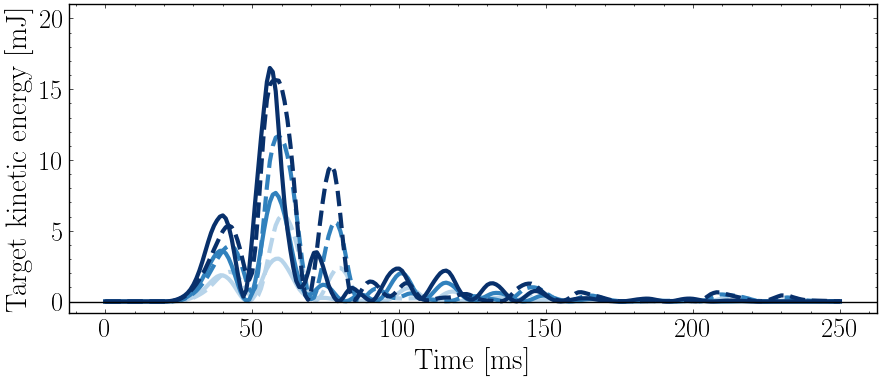

In [22]:
comparison_data_paper = comparison_data.loc[[3, 5, 7]]
fig, axes = plot_energy_evolution_list(
    comparison_data_paper,
    block_ids="target",
    figsize=(8.8, 3.8),
    grid=False,
    fontsize=21,
)
axes.legend().remove()
axes.set_ylim(None, 21)
axes.tick_params(labelsize=19)
# Make spines 1pt thick
for spine in axes.spines.values():
    spine.set_linewidth(1)
out_path = Path(
    f"{out_folder}/{optimization_filename}/profiles/amplitude_{[round(float(v),1) for v in comparison_data_paper.amplitude.values.tolist()]}_kinetic_energy_evolution_target.png")
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_path, bbox_inches="tight", dpi=300)

#### Strain and kinetic energy maps of the target behavior


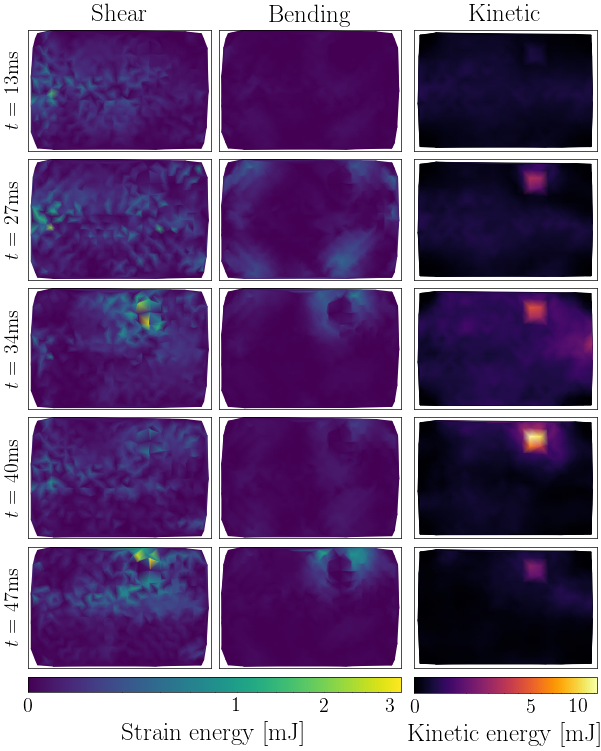

In [15]:
fig, axes = plot_strains_and_kinetic_energy_evolution(
    problem.solution_data,
    [40, 80, 100, 120, 140],
    grid=False,
    figsize=(6, 7.5),
    cmap_strains="viridis",
    show_ticks=False,
    fontsize=18,
    time_label_pos="left",
)
out_path = Path(f"{out_folder}/{optimization_filename}/profiles/strains_and_kinetic_energy_evolution.png")
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(
    out_path, bbox_inches="tight", dpi=300)

#### Snapshots of the deformed configuration with experimental input


##### Simulation


In [40]:
from difflexmm.plotting import generate_frames

xlim, ylim = problem.geometry.get_xy_limits(
    *design_values) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])


generate_frames(
    comparison_data.loc[7].simulation_data,
    field="v in m/s",
    deformed=True,
    frame_range=[30, 50, 55, 60, 70],
    figsize=(8.2, 5),
    xlim=xlim,
    ylim=ylim,
    cmap="inferno",
    dpi=300,
    legend_label="Velocity [m/s]",
    fontsize=20,
    ticksize=18,
    axis=False,
    out_dir=f"{out_folder}/{optimization_filename}/snapshots/sim",
    field_values=jnp.linalg.norm(
        comparison_data.loc[7].simulation_data.fields[:, 1, :, :2]/1000, axis=-1),
)

##### Experiment


In [34]:
import numpy as np
from difflexmm.geometry import current_coordinates


def plot_tracked_video_frame(video_filename, tracked_data, frame_number, timepoint, calib_xy, ROI_X, ROI_Y, alpha_overlay=0.8, origin_px=(0, 0), cmap="inferno", figsize=(8, 5)):
    # Load the video named with the label of the simulation using opencv
    video = cv2.VideoCapture(f"{video_filename}")
    # Get frame number 100
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    # Read the frame
    _, frame = video.read()
    # Add alpha channel
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2RGBA)
    # Restrict the frame to the ROI
    frame = cv2.flip(frame, 0)
    frame = frame[ROI_Y[0]:ROI_Y[1], ROI_X[0]:ROI_X[1]]
    origin_px = np.array(origin_px)

    # Compute current configuration of the blocks
    block_coordinates = current_coordinates(
        vertices=tracked_data.centroid_node_vectors,
        centroids=tracked_data.block_centroids,
        angles=tracked_data.fields[timepoint, 0, :, 2],
        displacements=tracked_data.fields[timepoint, 0, :, :2],
    )
    # Compute the field values
    field_values = np.linalg.norm(tracked_data.fields[timepoint, 1, :, :2], axis=-1)
    # field_values_max = np.linalg.norm(comparison_data.loc[7].tracked_data.fields[:, 1, :, :2], axis=-1).max()
    # Make a colormap
    cmap = plt.cm.get_cmap("inferno")
    # Normalize the field values
    norm = plt.Normalize(vmin=0, vmax=field_values.max())
    # Map the normalized values to colors
    field_colors = cmap(norm(field_values))
    # Draw the blocks
    overlay = frame.copy()
    for block, color in zip(block_coordinates, field_colors):
        # Convert the block coordinates to pixels
        block_px = (np.array(block) / calib_xy[0]).astype(int) + origin_px
        # Draw the shape with the color and opacity 0.5
        cv2.fillPoly(
            overlay,
            pts=[block_px],
            # Color the block according to the field value
            color=(color[0]*255, color[1]*255, color[2]*255, 255),
        )
    # Add the overlay to the frame
    frame = cv2.addWeighted(overlay, alpha_overlay, frame, 1-alpha_overlay, 0)

    # Show the frame
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    ax.imshow(frame, origin="lower")
    ax.axis("off")

    return fig, ax


/tmp/ipykernel_4130/33147003.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("inferno")


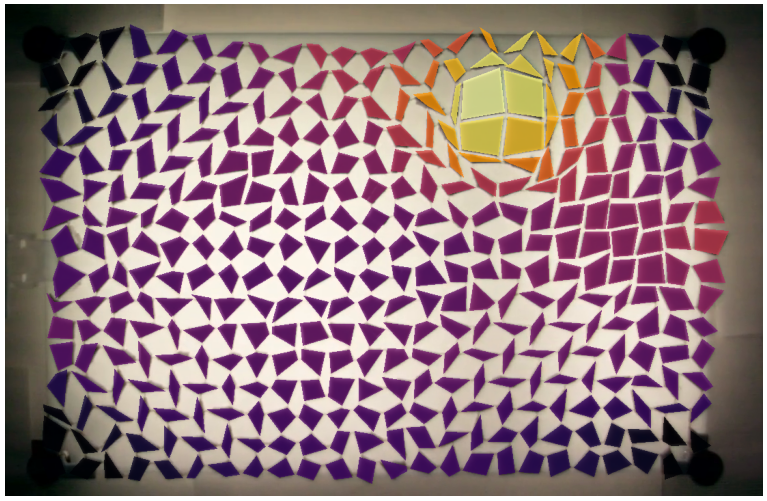

In [35]:
fig, axes = plot_tracked_video_frame(
    video_filename=f"{data_folder}/{design_name}/videos/{comparison_data.loc[7].label}.mp4",
    tracked_data=comparison_data.loc[7].tracked_data,
    frame_number=107,
    timepoint=55,
    calib_xy=(0.365, 0.365),  # mm/px
    ROI_X=(130, 1240),
    ROI_Y=(0, 720),
    origin_px=(71, 41),  # px
    figsize=(8, 5),
)
path = Path(
    f"{out_folder}/{optimization_filename}/snapshots/exp/{comparison_data.loc[7].label}.png")
# Make sure parents directories exist
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(str(path), dpi=300, bbox_inches="tight", pad_inches=0)

#### Movie frames for SI - Movie S1

In [17]:
from matplotlib import patches
import numpy as np
from difflexmm.geometry import current_coordinates


def plot_tracked_video_frame(video_filename, tracked_data, frame_number, timepoint, calib_xy, ROI_X, ROI_Y, alpha_overlay=0.8, origin_px=(0, 0), cmap="inferno", figsize=(8, 5)):
    # Load the video named with the label of the simulation using opencv
    video = cv2.VideoCapture(f"{video_filename}")
    # Get frame number 100
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    # Read the frame
    _, frame = video.read()
    # Add alpha channel
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2RGBA)
    # Restrict the frame to the ROI
    frame = cv2.flip(frame, 0)
    frame = frame[ROI_Y[0]:ROI_Y[1], ROI_X[0]:ROI_X[1]]
    origin_px = np.array(origin_px)

    # Compute current configuration of the blocks
    block_coordinates = current_coordinates(
        vertices=tracked_data.centroid_node_vectors,
        centroids=tracked_data.block_centroids,
        angles=tracked_data.fields[timepoint, 0, :, 2],
        displacements=tracked_data.fields[timepoint, 0, :, :2],
    )
    # Compute the field values
    field_values = np.linalg.norm(
        tracked_data.fields[timepoint, 1, :, :2], axis=-1)
    field_values_max = np.linalg.norm(
        tracked_data.fields[:, 1, :, :2], axis=-1).max()
    # Make a colormap
    cmap = plt.get_cmap("inferno")
    # Normalize the field values
    norm = plt.Normalize(vmin=0, vmax=field_values_max)
    # Map the normalized values to colors
    field_colors = cmap(norm(field_values))
    # Draw the blocks
    overlay = frame.copy()
    for block, color in zip(block_coordinates, field_colors):
        # Convert the block coordinates to pixels
        block_px = (np.array(block) / calib_xy[0]).astype(int) + origin_px
        # Draw the shape with the color and opacity 0.5
        cv2.fillPoly(
            overlay,
            pts=[block_px],
            # Color the block according to the field value
            color=(color[0]*255, color[1]*255, color[2]*255, 255),
        )
    # Add the overlay to the frame
    frame = cv2.addWeighted(overlay, alpha_overlay, frame, 1-alpha_overlay, 0)

    # Show the frame
    fig, ax = plt.subplots(figsize=figsize)
    # Add timepoint annotation in the bootom left corner
    ax.set_position([0, 0, 1, 1])
    ax.imshow(frame, origin="lower")
    # Add rectangle below text
    rect = patches.Rectangle((5, 5), 205, 40, linewidth=1, edgecolor="black", facecolor="black", alpha=0.9)
    ax.add_patch(rect)
    ax.text(15, 5, f"$t = {timepoint:.0f}"+"\\,\\text{ms}$",
            fontsize=12, color="white", ha="left", va="bottom")
    ax.axis("off")

    return fig, ax

In [ ]:
timepoints = range(0, 200, 1)
plt.ioff()
for timepoint in timepoints:
    fig, axes = plot_tracked_video_frame(
        video_filename=f"videos/{comparison_data.loc[7].label}.mp4",
        tracked_data=comparison_data.loc[7].tracked_data,
        frame_number=50+timepoint,
        timepoint=timepoint,  # 47,
        calib_xy=(0.365, 0.365),  # mm/px
        ROI_X=(130, 1240),
        ROI_Y=(0, 720),
        origin_px=(71, 41),  # px
        figsize=(6, 3),
    )
    # Make sure the directory exists
    out_path = Path(
        f"{out_folder}/{optimization_filename}/movie/tracked_frames_movie/frame_{timepoint:04d}.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(
        str(out_path),
        # bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )
    plt.close(fig)
    print(f"Frame {timepoint} done.")
plt.ion()

### Animation of simulation


In [ ]:
# Animation simulated experiments
xlim, ylim = problem.geometry.get_xy_limits(*design_values) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])

for row in simulation_data.itertuples():
    generate_animation(
        row.data,
        frame_range=jnp.arange(0, row.data.timepoints.shape[0], 2),
        field="u",
        deformed=True,
        out_filename=f"{out_folder}/{optimization_filename}/simulation_exp/{row.label}",
        xlim=xlim,
        ylim=ylim,
        figsize=(8, 5),
        fps=30,
        dpi=300,
        cmap="inferno",
        grid=False,
    )
